#### Welcome to the pyWWT visualization notebook!

This notebook demonstrates a PDS search API use case by visualizing Galileo Orbiter's magnetosphere measurement campaign and displays pyWWT's ability to visualize orbit data and overlay instrument data onto regions of interest.

To properly run this code, ensure that you have followed the steps outlined in the README.md file. Additionally, ensure that you have opened an "AAS Worldwide Telescope" launcher in your notebook work space. To do this simply go to File -> New Launcher and (if configured correctly) click the AAS WWT icon. See [WWTs Jupyter Application](https://pywwt.readthedocs.io/en/stable/jupyterlab.html) for troubleshooting and further setup.

# Step 0: Import Libraries and download pds4_tools

In [18]:
from __future__ import print_function
import __future__
import pandas as pd
import numpy as np

import requests
import spiceypy
import os
import io
import pds4_tools

from datetime import datetime,timedelta
import matplotlib.dates as mdates
from astropy import units as u

from astropy.time import Time
from pywwt.jupyter import WWTJupyterWidget
from pywwt.jupyter import connect_to_app
from astropy.table import Table, hstack
import matplotlib.pyplot as plt

# Step 1: SPICE Kernel download function
 **download_and_load_spice_kernel:** For a number of reasons we don't want SPICE kernels living on the gitHub repo, so this function installs the necessary kernels to the users local machine.

In [44]:


def download_and_load_spice_kernel(p_url):
    if not os.access('.spice_kernels',os.F_OK):
        os.mkdir('.spice_kernels')

    kernel_dir = os.path.join(".spice_kernels")
#     os.makedirs(kernel_dir, exist_ok=True)
    file_path = os.path.join(kernel_dir, os.path.basename(p_url))
    if not os.path.exists(file_path):
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 200:
            print('Successfully loaded:',os.path.basename(p_url))

            open(file_path, "wb").write(r.content)
        spiceypy.furnsh(file_path)
    else:
        print('"',os.path.basename(p_url), '" already exists. Skipping download.')
            


# Step 2: Load SPICE Kernels
Import the necessary SPICE Kernels and download them to on the local environment using **download_and_load_spice_kernel**.

In [45]:

KERNEL_URLS = [
    #generic LSK
    "https://naif.jpl.nasa.gov/pub/naif/pds/data/ody-m-spice-6-v1.0/odsp_1000/data/lsk/naif0008.tls",
    #Galileo SC SPK
    "https://naif.jpl.nasa.gov/pub/naif/GLL/kernels/spk/gll_951120_021126_raj2021.bsp"
]
for url in KERNEL_URLS:
    download_and_load_spice_kernel(url)
    

" naif0008.tls " already exists. Skipping download.
" gll_951120_021126_raj2021.bsp " already exists. Skipping download.


# Get Products from Search API

Utilize the PDS registry API to grab the magnetometer data for the Galileo Orbiter.

In [46]:
#High-res magnetometer data
# collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-highres-magnetosphere::1.0"
#Low-res magnetometer data
collection_lid = "urn:nasa:pds:galileo-mag-jup-calibrated:data-magspheric-survey::1.0"

url = f"https://pds.nasa.gov/api/search/1/products/{collection_lid}/members"

fields = [
    "lid",
    "vid",
    "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time",
    "pds:Target_Identification.pds:name",
    "ops:Label_File_Info.ops:file_ref",
    "pds:Field_Character.pds:name",
    "pds:Field_Character.pds:field_length"
]

#These search features do not work
start_time = "1996-11-01T00:00:00.00Z"
target_type = "Ganymede"

params = dict(
    fields=",".join(fields),
    q=f'((pds:Time_Coordinates.pds:start_date_time gt "{start_time}") and (pds:Target_Identification.pds:name eq "{target_type}"))',
    limit = 200
)


headers = dict(Accept="application/csv")
response = requests.get(
    url,
    params=params,
    headers=headers
)

# Step 3: Store results in a DataFrame and print contents for reference

In [41]:
products_csv_stream = io.StringIO(response.content.decode('utf-8'))
products_df_tot = pd.read_csv(products_csv_stream)

# change columns order
products_df_tot = products_df_tot[fields]
products_df_tot.sort_values(by = 'pds:Time_Coordinates.pds:start_date_time',inplace = True)

#User specified time range
start_time = pd.to_datetime('1996-07-19T11:00:00Z')
end_time = pd.to_datetime('1997-01-19T15:00:00Z')

# Filter the DataFrame within the time range
t_str = 'pds:Time_Coordinates.pds:start_date_time'
products_df = products_df_tot[(pd.to_datetime(products_df_tot[t_str]) >= start_time) & (pd.to_datetime(products_df_tot[t_str]) <= end_time)]

display(products_df[["lid",
    "vid",
    "pds:Time_Coordinates.pds:start_date_time",
    "pds:Time_Coordinates.pds:stop_date_time",
    "pds:Target_Identification.pds:name",
    "ops:Label_File_Info.ops:file_ref"]])

,lid,vid,pds:Time_Coordinates.pds:start_date_time,pds:Time_Coordinates.pds:stop_date_time,pds:Target_Identification.pds:name,ops:Label_File_Info.ops:file_ref
96,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
7,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
6,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:40.392Z,1996-11-02T11:44:01.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
5,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-09-01T16:00:48.392Z,1996-11-02T11:44:09.104Z,"[Jupiter, Ganymede]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
99,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
100,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
98,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:49.095Z,1996-12-14T23:58:52.842Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
97,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-11-02T16:02:57.095Z,1996-12-14T23:59:00.842Z,"[Jupiter, Callisto]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
53,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-12-15T00:18:32.842Z,1997-01-07T23:21:33.122Z,"[Jupiter, Europa]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...
102,urn:nasa:pds:galileo-mag-jup-calibrated:data-m...,1.0,1996-12-15T00:18:32.842Z,1997-01-07T23:21:33.122Z,"[Jupiter, Europa]",https://pds-ppi.igpp.ucla.edu/data/galileo-mag...


# Step 4: Utilize pds4_tools utility to load each xml member.

In [42]:
col_name_str = products_df_tot['pds:Field_Character.pds:name'][0]
col_name = [item.strip() for item in col_name_str[1:-1].split(',')]

xml_urls = [xml_url for xml_url in products_df['ops:Label_File_Info.ops:file_ref'] if 'IRC' in xml_url]

combined_data = None
for xml_url in xml_urls:
    prod_struct = pds4_tools.read(xml_url, quiet = True)
    data_grab = np.array(prod_struct[0]['SAMPLE TIME', 'B-FIELD MAGNITUDE'])
    combined_data = data_grab if combined_data is None else np.concatenate((combined_data, data_grab))

debug


# Step 4: Obtain ephemeris for mag measurements

Obtain the position and velocity values at each magnetometer measurement timestamp using the **get_sta** function.

***Note: You can change the number of data points you would like to plot by changing the sample variable. The higher it is, the fewer data points you will plot.***

In [43]:
sample = 100
trunc_data_tot = combined_data[1::sample]

print('Obtaining ephemeris for magnetometer readings...')
df = Table(trunc_data_tot)


mag_ephem_data = []
for t in trunc_data_tot['SAMPLE TIME']:
        et = spiceypy.str2et( t )
        [state, ltime] = spiceypy.spkezr( '5', et, 'J2000', 'LT+S', '-77')
        mag_ephem_data.append(state[0:3])

print("Number of magnetometer readings to plot: "+ str(len(mag_ephem_data)))


Obtaining ephemeris for magnetometer readings...
Number of magnetometer readings to plot: 2487


# Plot magnitude relative to distance

/var/folders/t7/tdt4vrqj57x7cdkbnm27lcbw0000gq/T/ipykernel_4213/3284598759.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will b

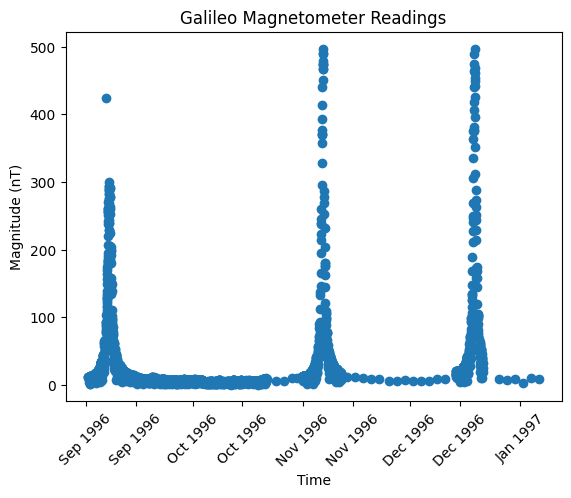

In [10]:
mag_datetime = [datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f") for t in trunc_data_tot['SAMPLE TIME']]
fig, ax = plt.subplots()
cm = ax.scatter(mag_datetime,trunc_data_tot['B-FIELD MAGNITUDE'])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel("Time")
plt.locator_params(axis='x', nbins=10)
plt.ylabel("Magnitude (nT)")
plt.title("Galileo Magnetometer Readings")

plt.show()

# fig_2, mag_d = plt.subplots()
# distance = distance = np.linalg.norm(mag_ephem_data, axis=1)
#
# cm = mag_d.scatter(distance,df['data'],c = df['data'], cmap = 'viridis' )
#
# plt.xlabel("Distance [km]")
# plt.ylabel("Magnitude (nT)")
# plt.title("Galileo Magnetometer Readings vs Altitude")
#
# cbar = plt.colorbar(cm)
# cbar.set_label("Magnitude (nT)")
# plt.show()

# Step 5: Obtain ephemeris for orbits

Get the ephemeris for the orbits between the first magnetometer measurement, and the last. This is used for better visualizing the orbit data. 

In [17]:
print("Filling in ephemeris data...")

start_time = mag_datetime[0]
end_time = mag_datetime[len(trunc_data_tot)-1]

ephem_time = np.arange(start_time, end_time, timedelta(hours=1)).astype(datetime)

ephem_iso = [ephem_t.replace(tzinfo=None).isoformat() for ephem_t in ephem_time]
ephem_data = []

for t in ephem_iso:
        et = spiceypy.str2et( t )
        [state, ltime] = spiceypy.spkezr( '5', et, 'J2000', 'LT+S', '-77')
        ephem_data.append(state[0:3])

print('Finished')


Filling in ephemeris data...
Finished


# Step 6: Organize the data for pyWWT

This step organizes all the data variables into tables for pyWWT. A table is generated for the magnetometer data and another for the ephemeris data.

In [22]:
mag_tab_data = Table(np.array(mag_ephem_data), names = ['X', 'Y', 'Z'])
ephem_tab = Table(np.array(ephem_data), names = ['X', 'Y', 'Z'])

mag_tab = hstack([Table(trunc_data_tot), mag_tab_data])
ephem_tab['Time'] = ephem_iso
            
print('Done!')

Done!


# Step 7: Connect pyWWT Widget

***Before proceeding, ensure that you have another tab open in the notebook for the AAS WorldWide Telescope widget***

Instantiate the WWTJupyterWidget and await connection.

In [23]:
#Connect pyWWT widget

wwt = WWTJupyterWidget()
wwt = await connect_to_app().becomes_ready()
print('Successful Connection')
wwt.reset()

Successful Connection


# Step 8: Set view and load data

Set the WWT view to the solar system and load in the magnetometer data and ephemeris data via table layers. Once complete, in the pyWWT widget the view will be centered on Jupiter. Zoom in to see the results!

In [27]:
wwt.set_current_time(Time('1995-12-07 15:21:01.776000'))
wwt.set_view("solar system")
layer = wwt.layers.add_table_layer(table = mag_tab, frame = 'jupiter',
                                  coord_type = 'rectangular',
                                  x_att = 'X', y_att = 'Y', z_att = 'Z')
layer.xyz_unit = 'km'
layer.far_side_visible = True

layer.cmap_att = 'B-FIELD MAGNITUDE'
layer.cmap.vmin = min(mag_tab['B-FIELD MAGNITUDE'])
layer.cmap.vmax = max(mag_tab['B-FIELD MAGNITUDE'])

layer.size_scale = 250
layer.far_side_visible = True
layer.marker_type = 'point'
layer.opacity = 0.25

# layer.name = "name"

layer.marker_scale = 'world'

eph = wwt.layers.add_table_layer(table = ephem_tab, frame = 'jupiter',
                                  coord_type = 'rectangular',
                                  x_att = 'X', y_att = 'Y', z_att = 'Z')
eph.xyz_unit = 'km'
eph.far_side_visible = True
eph.color = (.2, .2, .6)
eph.size_scale = 16
eph.far_side_visible = True

In [28]:
wwt.solar_system.track_object('Jupiter')


# Step 8:

Note the below code is still a work in progress and will not function as intended.

In [17]:
# start_time = ephem_tab['Time'][0]
# theta_dot = 1.76**-4 *3600 # rad/hour
# thetas = [theta_dot * (datetime.fromisoformat(start_time) - datetime.fromisoformat(curr_time)).total_seconds()/3600 for curr_time in ephem_tab['Time']]

# trans_mat = [np.array([[np.cos(theta), -np.sin(theta)] , [np.sin(theta), np.cos(theta)]]) for theta in thetas]

# trans_xy = [np.dot(trans_mat,np.array([[x] , [y]])) for x,y in zip(ephem_tab['X'],ephem_tab['Y'])]

# for i in range(len(ephem_tab)):
#     trans_mat = [np.array([np.cos(thetas[i]), -np.sin(thetas[i])] , [np.sin(thetas[i]), np.cos(thetas[i])])]
#     trans_xy[i] = [np.dot(trans_mat,np.array([x] , [y])) for x,y in zip(ephem_tab['X'][i],ephem_tab['Y'])[i]]
   




In [46]:
#Animate

eph.time_series = True
eph.time_att = 'Time'
eph.time_decay = 500 * u.hour

# layer.time_series = True
# layer.time_att = 'Time'
# layer.time_decay = 10000 * u.hour

my_time = Time('1996-12-07 15:21:01.776000')
wwt.set_current_time(my_time)

wwt.play_time(rate=10000)

In [47]:
wwt.pause_time()